In [1]:
import numpy as np
import jax.numpy as jnp
import jax
import bayes3d as b
import time
from PIL import Image
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
import cv2
import trimesh
import os
import glob
import bayes3d.neural
import pickle
# Can be helpful for debugging:
# jax.config.update('jax_enable_checks', True) 
# from bayes3d.neural.segmentation import carvekit_get_foreground_mask
import genjax
import bayes3d.genjax

In [2]:
import viser
server = viser.ViserServer()

╭─────────────── viser ───────────────╮
│             ╷                       │
│   HTTP      │ http://0.0.0.0:8081   │
│   Websocket │ ws://0.0.0.0:8081     │
│             ╵                       │
╰─────────────────────────────────────╯

In [3]:
importance_jit = jax.jit(b.genjax.model.importance)
key = jax.random.PRNGKey(10)

dict_keys(['rgbPixels', 'depthPixels', 'segmentationMaskBuffer', 'camera_pose', 'camera_matrix'])


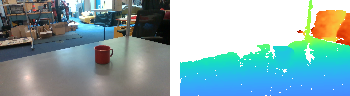

In [4]:
file = os.path.join(b.utils.get_assets_dir(),"tutorial_mug_image.pkl")
all_data = pickle.load(open(file, "rb"))
IDX = 0
data = all_data[IDX]
print(data["camera_image"].keys())
K = data["camera_image"]['camera_matrix'][0]
rgb = data["camera_image"]['rgbPixels']
depth = data["camera_image"]['depthPixels']
camera_pose = data["camera_image"]['camera_pose']
camera_pose = b.t3d.pybullet_pose_to_transform(camera_pose)
fx, fy, cx, cy = K[0,0],K[1,1],K[0,2],K[1,2]
h,w = depth.shape
near = 0.001
rgbd_original = b.RGBD(rgb, depth, camera_pose, b.Intrinsics(h,w,fx,fy,cx,cy,0.001,10000.0))
scaling_factor = 0.2
rgbd_scaled_down = b.RGBD.scale_rgbd(rgbd_original, scaling_factor)
b.hstack_images([b.get_rgb_image(rgbd_scaled_down.rgb), b.get_depth_image(rgbd_scaled_down.depth,max_val=2.5)])

In [5]:
table_pose, plane_dims = b.utils.infer_table_plane(
    b.unproject_depth(rgbd_scaled_down.depth, rgbd_scaled_down.intrinsics),
    jnp.eye(4), rgbd_scaled_down.intrinsics, 
    ransac_threshold=0.001, inlier_threshold=0.001, segmentation_threshold=0.1
)

(viser) Connection opened (0, 1 total), 3 persistent messages

In [18]:
server.add_point_cloud(
    "/cloud",
    points=np.array(b.unproject_depth(rgbd_scaled_down.depth, rgbd_scaled_down.intrinsics).reshape(-1,3)),
    colors=np.array(rgbd_scaled_down.rgb.reshape(-1,3)),
    point_size=0.01
)

PointCloudHandle(_impl=_SceneNodeHandleState(name='/cloud', api=<viser._viser.ViserServer object at 0x7fc6c981ff50>, wxyz=array([1., 0., 0., 0.]), position=array([0., 0., 0.]), visible=True, click_cb=None))

In [7]:
server.add_frame(
    "/table",
    position=np.array(table_pose[:3,3]),
    wxyz=b.rotation_matrix_to_quaternion(table_pose[:3,:3]),
    axes_length=0.1,
    axes_radius=0.005
)

FrameHandle(_impl=_SceneNodeHandleState(name='/table', api=<viser._viser.ViserServer object at 0x7fc6c981ff50>, wxyz=array([ 0.10174274,  0.1909879 ,  0.79682994, -0.56346023], dtype=float32), position=array([0.13303192, 0.06902084, 0.7311834 ], dtype=float32), visible=True, click_cb=None))

In [8]:
b.setup_renderer(rgbd_scaled_down.intrinsics)
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
mesh_path = os.path.join(model_dir,"obj_" + "{}".format(13+1).rjust(6, '0') + ".ply")
b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=1.0/1000.0)
mesh_path = os.path.join(model_dir,"obj_" + "{}".format(10+1).rjust(6, '0') + ".ply")
b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=1.0/1000.0)
b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/1000000000.0)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (192, 96, 1024)


In [9]:
width = 0.03
ang = jnp.pi
num_position_grids = 51
num_angle_grids = 51
contact_param_deltas = b.utils.make_translation_grid_enumeration_3d(
    -width, -width, -ang,
    width, width, ang,
    num_position_grids,num_position_grids,num_angle_grids
)

grid_params = [
    (0.5, jnp.pi, (15,15,15)), (0.2, jnp.pi, (15,15,15)), (0.1, jnp.pi, (15,15,15)),
    (0.05, jnp.pi/3, (15,15,15)),
    (0.02, jnp.pi, (9,9,51))
    , (0.01, jnp.pi/5, (15,15,15)),
      (0.01, 0.0, (31,31,1)),(0.05, 0.0, (31,31,1))
]
contact_param_gridding_schedule = [
    b.utils.make_translation_grid_enumeration_3d(
        -x, -x, -ang,
        x, x, ang,
        *nums
    )
    for (x,ang,nums) in grid_params
]

OBJECT_NUMBER = 1
address = f"contact_params_{OBJECT_NUMBER}"
enumerators = b.genjax.make_enumerator([address])

def c2f_(potential_trace, contact_param_gridding_schedule):
    cp = potential_trace[address]
    for cp_grid in contact_param_gridding_schedule:
        cps = cp + cp_grid
        scores = enumerators.enumerate_choices_get_scores(potential_trace, key, cps)
        cp = cps[scores.argmax()]
    potential_trace = enumerators.update_choices(potential_trace, key, cp)
    return potential_trace, scores.argmax()
c2f = jax.jit(c2f_)

In [23]:
def viz_trace_viser(server, trace, colors=None):
    server.reset_scene()
    indices = b.genjax.get_indices(trace)
    poses = b.genjax.get_poses(trace)
    for i in range(len(poses)):
        server.add_mesh_trimesh(
            name="/trimesh",
            mesh=b.RENDERER.meshes[indices[i]],
            position=np.array(poses[i][:3,3]),
            wxyz=b.rotation_matrix_to_quaternion(poses[i][:3,:3]),
        )
    server.add_point_cloud(
        "/cloud",
        points=np.array(trace["image"].reshape(-1,3)),
        colors=np.array([1.0, 0.0, 0.0]),
        point_size=0.01
    )

In [24]:
obs_img = b.unproject_depth_jit(rgbd_scaled_down.depth, rgbd_scaled_down.intrinsics)
trace, weight = importance_jit(key, genjax.choice_map({
    "parent_0": -1,
    "parent_1": 0,
    "id_0": jnp.int32(2),
    "id_1": jnp.int32(0),
    "camera_pose": jnp.eye(4),
    "root_pose_0": table_pose,
    "face_parent_1": 2,
    "face_child_1": 3,
    "image": obs_img,
    "variance": 0.03,
    "outlier_prob": 0.0001,
}), (
    jnp.arange(2),
    jnp.arange(22),
    jnp.array([-jnp.ones(3)*100.0, jnp.ones(3)*100.0]),
    jnp.array([jnp.array([-0.3, -0.3, -22*jnp.pi]), jnp.array([0.3, 0.3, 22*jnp.pi])]),
    b.RENDERER.model_box_dims)
)
print(trace.get_score())
viz_trace_viser(server, trace)


-57.049133


In [25]:
potential_trace = trace

In [26]:
import time
cp = potential_trace[address]
new_potential_trace = potential_trace
for cp_grid in contact_param_gridding_schedule:
    cps = cp + cp_grid
    scores = enumerators.enumerate_choices_get_scores(new_potential_trace, key, cps)
    cp = cps[scores.argmax()]
    new_potential_trace = enumerators.update_choices(new_potential_trace, key, cp)

In [27]:
viz_trace_viser(server, new_potential_trace)

In [38]:
%%time
key = jax.random.split(key,2)[0]
new_potential_trace = c2f(potential_trace, contact_param_gridding_schedule)[0]
print(new_potential_trace["contact_params_1"])
b.genjax.viz_trace_meshcat(new_potential_trace)

[0.10350819 0.08779351 1.7163045 ]
CPU times: user 8.78 s, sys: 123 ms, total: 8.91 s
Wall time: 7.76 s


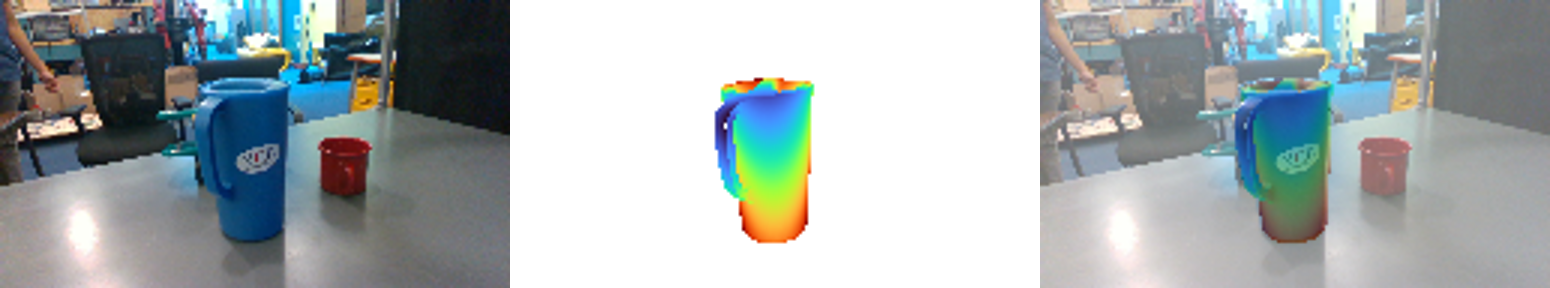

In [24]:
scaling_factor = 3.0
img = b.scale_image(b.get_depth_image(
    b.genjax.get_rendered_image(new_potential_trace)[...,2],
), scaling_factor)
rgb = b.scale_image(b.get_rgb_image(
    rgbd_scaled_down.rgb
),scaling_factor)

b.hstack_images([rgb, img, b.overlay_image(rgb, img, alpha=0.4)])